**Import Library**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys
import pickle
from tqdm.notebook import tqdm

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
import xgboost as xgb
import lightgbm as lgb

mpl.rc('font', family='New Gulim')
mpl.rc('axes', unicode_minus=False)

%matplotlib inline

**Import Data**

In [2]:
with open('./pickles/train.pkl', 'rb') as f: # 가공된 train 데이터
    train = pickle.load(f)

with open('./pickles/test.pkl', 'rb') as f: # 가공된 test 데이터
    test = pickle.load(f)

with open('./pickles/train_weather.pkl', 'rb') as f: # 기상 변수 가공된 train 데이터
    train_weather = pickle.load(f)

with open('./pickles/test_weather.pkl', 'rb') as f: # 기상 변수 가공된 test 데이터
    test_weather = pickle.load(f)

print('가공된 train 데이터 : ', train.shape)
print('가공된 test 데이터 : ', test.shape)
print('가공된 train_weather 데이터 : ', train_weather.shape)
print('가공된 test_weather 데이터 : ', test_weather.shape)

가공된 train 데이터 :  (35379, 20)
가공된 test 데이터 :  (2716, 20)
가공된 train_weather 데이터 :  (35379, 19)
가공된 test_weather 데이터 :  (2716, 19)


In [3]:
train_final = pd.concat([train, train_weather[['rain', 'temp', 'storm', 'hot', 'PM10']]], axis = 1) # 최종 Train 데이터
test_final = pd.concat([test, test_weather[['rain', 'temp', 'storm', 'hot', 'PM10']]], axis = 1) # 최종 Test 데이터

print('최종 Train Data 형태 : ', train_final.shape)
print('최종 Test Data 형태 : ', test_final.shape)

최종 Train Data 형태 :  (35379, 25)
최종 Test Data 형태 :  (2716, 25)


# Data Preprocessing

In [4]:
train_final.drop(['방송일시','마더코드','상품코드','date', '판매량'],axis=1, inplace = True) # 문자형 변수들 제외
test_idx = test_final['index']
test_final.drop(['index','방송일시','마더코드','상품코드','date'],axis=1, inplace = True)

transform_features1=['노출(분)','판매단가'] # 노출(분), 판매단가 변수들이 문자형으로 돼있는 것을 확인, 수치형 자료로 변환 
for feature in transform_features1:
    train_final[feature]=train_final[feature].astype('int')
    test_final[feature]=test_final[feature].astype('int') 

In [5]:
def make_onehot(tr, te, trans_feat): # 범주형 변수들의 원-핫 인코딩
    for feature in trans_feat:
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(tr[[feature]])
        
        column_name = enc.get_feature_names([feature])
        
        feat_tr = pd.DataFrame(enc.transform(tr[[feature]]).toarray(), columns=column_name)
        feat_te = pd.DataFrame(enc.transform(te[[feature]]).toarray(), columns=column_name)

        tr = tr.join(feat_tr)
        tr = tr.drop([feature], axis = 1)
        te = te.join(feat_te)
        te = te.drop([feature], axis = 1)
        
    return tr, te

In [6]:
cate_transform_features = ['brand', 'hour', 'weekday', 'month', 'prime', 'season', '초중말', '방송순서',
                           'rain', 'storm', 'hot', 'PM10', 'discount']
train_final, test_final = make_onehot(train_final, test_final, cate_transform_features)
print(train_final.shape) # 원-핫 인코딩 완료
print(test_final.shape)

(35379, 77)
(2716, 77)


In [7]:
def make_minmax(tr, te, trans_feat): # 연속형 변수들의 MinMax 정규화
    scaler = MinMaxScaler()
    for feature in trans_feat:
        train_feature = tr[feature].values.reshape(-1, 1)
        train_scaled_feature = scaler.fit_transform(train_feature)
        tr[f'scaled_{feature}'] = train_scaled_feature
        tr = tr.drop([feature], axis = 1)
        
        test_feature = te[feature].values.reshape(-1, 1)
        test_scaled_feature = scaler.fit_transform(test_feature)
        te[f'scaled_{feature}'] = test_scaled_feature
        te = te.drop([feature], axis = 1)
        
    return tr, te

train_final, test_final = make_minmax(train_final, test_final, ['판매단가', '노출(분)', 'temp'])

In [8]:
# MAPE 평가지표

def mape(y_true,y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [9]:
kind_list = list(set(train_final['상품군']))

def make_data(data, kind):
    new_df = data[data['상품군'] == kind]
    X = new_df.drop(['상품명', '상품군', '취급액', 'day'], axis = 1)
    y = new_df['취급액']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 1818)    
    
    return X_train, X_valid, y_train, y_valid

# Modeling

## LightGBM
기존 Gradient Boosting보다 속도가 빠르며, 과적합을 방지할 수 있어 좋은 예측 결과를 만들 수 있다.   

적은 데이터 세트에 적합하는 경우 과적합이 발생하기 쉽다.   

- learning_rate : GBM은 초기의 추정값에서 시작하여 각각의Tree 결과를 사용하여 추정값을 업데이트 하는 과정에서 발생하는 변화의 크기   

- max_depth : 각 의사결정나무의 깊이를 설정. 트리가 깊어질수록 더 잘게 분류를 시키므로 일반적으론 정확도가 높아진다.   

- num_leaves : 전체 Tree의 leave 수

In [10]:
from lightgbm import LGBMRegressor, plot_importance

In [11]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
mape_lgb_list = list()

for kind in tqdm(kind_list):
    X_train, X_valid, y_train, y_valid = make_data(data = train_final, kind = kind)
    lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818)
    params_lgb = {'objective' : ['regression'],
                  'metric' : ['mse'],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'max_depth' : [6,7],
                  'num_leaves' : [63, 127]}
    
    grid_lgb = GridSearchCV(lgb_reg, param_grid=params_lgb, cv = 5)
    grid_lgb.fit(X_train, y_train)
    pred_lgb = grid_lgb.predict(X_valid)
    mape_lgb=mape(y_valid, pred_lgb)
    mape_lgb_list.append(mape_lgb)
    print('상품군 : ', kind, '\n 최적 하이퍼 파라미터: ',grid_lgb.best_params_)
        
mape_lgb_df = pd.DataFrame({'kind' : kind_list, 'lgb_mape' : mape_lgb_list})
mape_lgb_df

상품군 :  잡화 
 최적 하이퍼 파라미터:  {'learning_rate': 0.05, 'max_depth': 7, 'metric': 'mse', 'num_leaves': 63, 'objective': 'regression'}
상품군 :  건강기능 
 최적 하이퍼 파라미터:  {'learning_rate': 0.01, 'max_depth': 7, 'metric': 'mse', 'num_leaves': 63, 'objective': 'regression'}
상품군 :  가전 
 최적 하이퍼 파라미터:  {'learning_rate': 0.05, 'max_depth': 6, 'metric': 'mse', 'num_leaves': 63, 'objective': 'regression'}
상품군 :  생활용품 
 최적 하이퍼 파라미터:  {'learning_rate': 0.1, 'max_depth': 7, 'metric': 'mse', 'num_leaves': 63, 'objective': 'regression'}
상품군 :  의류 
 최적 하이퍼 파라미터:  {'learning_rate': 0.05, 'max_depth': 6, 'metric': 'mse', 'num_leaves': 63, 'objective': 'regression'}
상품군 :  속옷 
 최적 하이퍼 파라미터:  {'learning_rate': 0.01, 'max_depth': 7, 'metric': 'mse', 'num_leaves': 63, 'objective': 'regression'}
상품군 :  가구 
 최적 하이퍼 파라미터:  {'learning_rate': 0.01, 'max_depth': 6, 'metric': 'mse', 'num_leaves': 63, 'objective': 'regression'}
상품군 :  주방 
 최적 하이퍼 파라미터:  {'learning_rate': 0.1, 'max_depth': 6, 'metric': 'mse', 'num_leaves': 63, '

,kind,lgb_mape
0,잡화,53.522425
1,건강기능,44.603927
2,가전,62.995166
3,생활용품,60.482734
4,의류,49.109365
5,속옷,86.608507
6,가구,64.015866
7,주방,53.131283
8,이미용,28.949799
9,침구,31.859083


## XGBoost
결정력이 약한 분류기를 다수 사용하는 과정에서 정확도를 높이는 기법   

Gradient Boosting 과정에서 과적합을 방지할 수 있다.   

계산 과정 추적이 어려워 변수의 중요도를 파악하기 어렵다.   

- eval_metric : 검증데이터에 적용되는 모델 선택 기준

- n_estimators : 생성할 tree의 개수

- learning_rate : GBM은 초기의 추정값에서 시작하여 각각의Tree 결과를 사용하여 추정값을 업데이트 하는 과정에서 발생하는 변화의 크기

- max_depth : 각 의사결정나무의 깊이를 설정. 트리가 깊어질수록 더 잘게 분류를 시키므로 일반적으론 정확도가 높아진다.

In [12]:
#-*- coding: utf-8 -*-
from tqdm.notebook import tqdm
mape_xgb_list = list()

for kind in tqdm(kind_list):
    X_train, X_valid, y_train, y_valid = make_data(data = train_final, kind = kind)
    xgb_reg = xgb.XGBRegressor( random_state=1818)
    params_xgb = {'objective' : ['reg:squarederror'],
                  'booster' : ['gbtree'],
                  'eval_metric' : ['rmse'],
                  'n_estimators' : [50, 100, 200],
                  'learning_rate' : [0.05, 0.1, 0.15],
                  'max_depth' : [4, 6, 8]
}
    
    grid_xgb = GridSearchCV(xgb_reg, param_grid=params_xgb, cv = 5)
    grid_xgb.fit(X_train, y_train)
    pred_xgb = grid_lgb.predict(X_valid)
    mape_xgb=mape(y_valid, pred_xgb)
    mape_xgb_list.append(mape_xgb)
    print('최적 하이퍼 파라미터:\n',grid_xgb.best_params_)
        
mape_xgb_df = pd.DataFrame({'kind' : kind_list, 'xgb_mape' : mape_xgb_list})
mape_xgb_df

최적 하이퍼 파라미터:
 {'booster': 'gbtree', 'eval_metric': 'rmse', 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 200, 'objective': 'reg:squarederror'}
최적 하이퍼 파라미터:
 {'booster': 'gbtree', 'eval_metric': 'rmse', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'objective': 'reg:squarederror'}
최적 하이퍼 파라미터:
 {'booster': 'gbtree', 'eval_metric': 'rmse', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'objective': 'reg:squarederror'}
최적 하이퍼 파라미터:
 {'booster': 'gbtree', 'eval_metric': 'rmse', 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 200, 'objective': 'reg:squarederror'}
최적 하이퍼 파라미터:
 {'booster': 'gbtree', 'eval_metric': 'rmse', 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 200, 'objective': 'reg:squarederror'}
최적 하이퍼 파라미터:
 {'booster': 'gbtree', 'eval_metric': 'rmse', 'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 200, 'objective': 'reg:squarederror'}
최적 하이퍼 파라미터:
 {'booster': 'gbtree', 'eval_metric': 'rmse', 'learning_rate': 0.15, 'max_dep

,kind,xgb_mape
0,잡화,336.271423
1,건강기능,114.958549
2,가전,375.174734
3,생활용품,488.564976
4,의류,163.161492
5,속옷,252.444737
6,가구,628.745813
7,주방,398.556878
8,이미용,56.260574
9,침구,400.567358


## RandomForset
다수의 의사결정나무를 이용하는 학습법   

여러 변수를 일괄적으로 다룰 수 있다.   

모델 중 메모리 소모가 가장 많으며 Training data의 양이 증가해도 성능이 급격히 향상하지 않는다.   

- n_estimators : 생성할 tree의 개수

- max_features : 최대 선택할 특성의 수

- max_depth : 각 의사결정나무의 깊이를 설정. 트리가 깊어질수록 더 잘게 분류를 시키므로 일반적으론 정확도가 높아진다.

In [14]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
mape_rf_list = list()

for kind in tqdm(kind_list):
    X_train, X_valid, y_train, y_valid = make_data(data = train_final, kind = kind)
    rf_reg = RandomForestRegressor(random_state=1818)
    params_rf={
    'n_estimators':[50,100,200],
    'max_depth':[6,8,10,12]}
    
    grid_rf = GridSearchCV(rf_reg, param_grid=params_rf, cv = 5)
    grid_rf.fit(X_train, y_train)
    pred_rf = grid_rf.predict(X_valid)
    mape_rf=mape(y_valid, pred_rf)
    mape_rf_list.append(mape_rf)
    print('최적 하이퍼 파라미터:\n',grid_rf.best_params_)
        
mape_rf_df = pd.DataFrame({'kind' : kind_list, 'rf_mape' : mape_rf_list})
mape_rf_df

최적 하이퍼 파라미터:
 {'max_depth': 12, 'n_estimators': 200}
최적 하이퍼 파라미터:
 {'max_depth': 10, 'n_estimators': 200}
최적 하이퍼 파라미터:
 {'max_depth': 12, 'n_estimators': 200}
최적 하이퍼 파라미터:
 {'max_depth': 12, 'n_estimators': 100}
최적 하이퍼 파라미터:
 {'max_depth': 12, 'n_estimators': 100}
최적 하이퍼 파라미터:
 {'max_depth': 10, 'n_estimators': 100}
최적 하이퍼 파라미터:
 {'max_depth': 8, 'n_estimators': 200}
최적 하이퍼 파라미터:
 {'max_depth': 12, 'n_estimators': 200}
최적 하이퍼 파라미터:
 {'max_depth': 12, 'n_estimators': 100}
최적 하이퍼 파라미터:
 {'max_depth': 12, 'n_estimators': 200}
최적 하이퍼 파라미터:
 {'max_depth': 12, 'n_estimators': 200}



,kind,rf_mape
0,잡화,62.784901
1,건강기능,53.750460
2,가전,68.218632
3,생활용품,78.946854
4,의류,55.339025
5,속옷,96.218039
6,가구,67.917156
7,주방,73.982114
8,이미용,27.628828
9,침구,31.260159


## Linear Model
직선 모형을 통해 변수의 효과(계수)와 유의성 등 변수에 대한 직관적인 판단이 가능하다.   

변수 간 다중공선성 발생 가능성이 높아 모델 성능 저하가 일어날 수 있다.   

데이터가 모두 선형으로 설명된다고 볼 수 없다.

In [15]:
from sklearn.linear_model import LinearRegression
mape_lm_list = list()
for kind in tqdm(kind_list):
    X_train, X_valid, y_train, y_valid = make_data(data = train_final, kind = kind)
    model = LinearRegression()
    model = model.fit(X_train, y_train)
    predict_lm = model.predict(X_valid)
    mape_lm = mape(y_valid,predict_lm)
    mape_lm_list.append(mape_lm)
    
mape_lm_df = pd.DataFrame({'kind' : kind_list, 'lm_mape' : mape_lm_list})
mape_lm_df

,kind,lm_mape
0,잡화,9.175197e+01
1,건강기능,3.641249e+12
2,가전,1.027350e+02
3,생활용품,1.475972e+02
4,의류,7.503433e+01
5,속옷,4.639285e+10
6,가구,9.311290e+01
7,주방,1.066908e+02
8,이미용,3.765041e+01
9,침구,5.686322e+01


In [16]:
print('XGboost 모델 활용시 평균 MAPE : ', mape_xgb_df['xgb_mape'].mean())
print('LightGBM 모델 활용시 평균 MAPE : ', mape_lgb_df['lgb_mape'].mean())
print('RandomForest 모델 활용시 평균 MAPE : ', mape_rf_df['rf_mape'].mean())

XGboost 모델 활용시 평균 MAPE :  296.06404926972795
LightGBM 모델 활용시 평균 MAPE :  52.4796513317124
RandomForest 모델 활용시 평균 MAPE :  60.63983767733957


MAPE 값
- Light GBM < Random Forest < XG Boost 

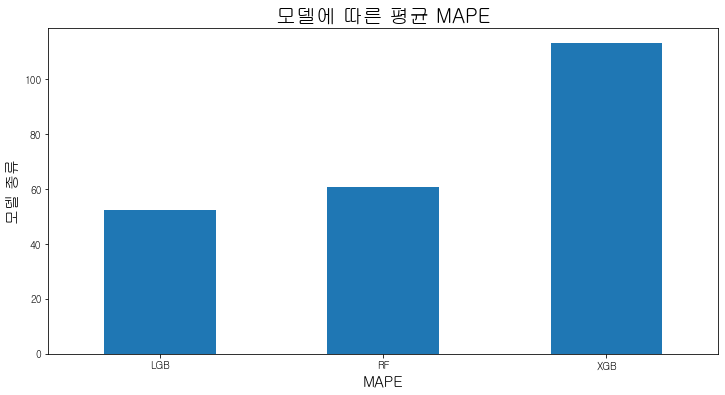

In [17]:
model_df = pd.Series([52.48,60.64,113.24])
index_dc=np.arange(3)
label_dc=['LGB','RF','XGB']

model_df.plot(kind='bar',figsize=(12,6))
title = '모델에 따른 평균 MAPE'
plt.title(title, fontsize = 20)
plt.xticks(index_dc,label_dc,rotation=0,fontsize=10)
plt.xlabel('MAPE',size=15)
plt.ylabel('모델 종류',size=15)
plt.savefig(f'./graphs/{title}.png')
plt.show()

In [18]:
final_mape_df=pd.concat([mape_lgb_df,mape_xgb_df['xgb_mape'],mape_rf_df['rf_mape']],axis=1)
final_mape_df

,kind,lgb_mape,xgb_mape,rf_mape
0,잡화,53.522425,336.271423,62.784901
1,건강기능,44.603927,114.958549,53.750460
2,가전,62.995166,375.174734,68.218632
3,생활용품,60.482734,488.564976,78.946854
4,의류,49.109365,163.161492,55.339025
5,속옷,86.608507,252.444737,96.218039
6,가구,64.015866,628.745813,67.917156
7,주방,53.131283,398.556878,73.982114
8,이미용,28.949799,56.260574,27.628828
9,침구,31.859083,400.567358,31.260159


# Final Predict   

- 각 상품군 별 실적을 예측한다.

In [19]:
test_final.columns

Index(['상품명', '상품군', '취급액', 'day', 'brand_0.0', 'brand_1.0', 'hour_00',
       'hour_01', 'hour_02', 'hour_06', 'hour_07', 'hour_08', 'hour_09',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'weekday_0.0', 'weekday_1.0', 'month_01',
       'month_02', 'month_03', 'month_04', 'month_05', 'month_06', 'month_07',
       'month_08', 'month_09', 'month_10', 'month_11', 'month_12', 'prime_0.0',
       'prime_1.0', 'season_0.0', 'season_1.0', 'season_2.0', 'season_3.0',
       '초중말_0.0', '초중말_1.0', '초중말_2.0', '방송순서_0.0', '방송순서_1.0', '방송순서_2.0',
       '방송순서_3.0', '방송순서_4.0', '방송순서_5.0', '방송순서_6.0', '방송순서_7.0', '방송순서_8.0',
       '방송순서_9.0', '방송순서_10.0', '방송순서_11.0', 'rain_0.0', 'rain_1.0',
       'storm_0.0', 'storm_1.0', 'hot_0.0', 'hot_1.0', 'PM10_0.0', 'PM10_1.0',
       'PM10_2.0', 'PM10_3.0', 'discount_0.0', 'discount_1.0', 'scaled_판매단가',
       'scaled_노출(분)',

In [20]:
train_final.columns

Index(['상품명', '상품군', '취급액', 'day', 'brand_0.0', 'brand_1.0', 'hour_00',
       'hour_01', 'hour_02', 'hour_06', 'hour_07', 'hour_08', 'hour_09',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'weekday_0.0', 'weekday_1.0', 'month_01',
       'month_02', 'month_03', 'month_04', 'month_05', 'month_06', 'month_07',
       'month_08', 'month_09', 'month_10', 'month_11', 'month_12', 'prime_0.0',
       'prime_1.0', 'season_0.0', 'season_1.0', 'season_2.0', 'season_3.0',
       '초중말_0.0', '초중말_1.0', '초중말_2.0', '방송순서_0.0', '방송순서_1.0', '방송순서_2.0',
       '방송순서_3.0', '방송순서_4.0', '방송순서_5.0', '방송순서_6.0', '방송순서_7.0', '방송순서_8.0',
       '방송순서_9.0', '방송순서_10.0', '방송순서_11.0', 'rain_0.0', 'rain_1.0',
       'storm_0.0', 'storm_1.0', 'hot_0.0', 'hot_1.0', 'PM10_0.0', 'PM10_1.0',
       'PM10_2.0', 'PM10_3.0', 'discount_0.0', 'discount_1.0', 'scaled_판매단가',
       'scaled_노출(분)',

## 속옷

In [21]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
final_df = pd.DataFrame(columns={'index','취급액'})
X_train, X_test, y_train= train_final.loc[train_final['상품군']=='속옷'].drop(['상품명','상품군','취급액','day'],axis=1),train_final.loc[train_final['상품군']=='속옷','취급액'],test_final.loc[test_final['상품군']=='속옷'].drop(['상품군','상품명','취급액','day'],axis=1)
y_idx = list(y_train.index)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818,
                           objective = 'regression',metric='mse',
                           learning_rate = 0.01,max_depth=7,num_leaves=63)
lgb_reg = lgb_reg.fit(X_train,X_test)
pred_lgb = list(lgb_reg.predict(y_train))
pred_df = pd.DataFrame({'index':y_idx,'취급액':pred_lgb})
final_df = pd.concat([final_df,pred_df],axis=0)
print(final_df.shape)

(329, 2)


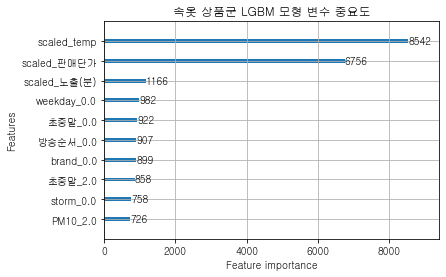

In [22]:
plot_importance(lgb_reg, max_num_features=10,title = '속옷 상품군 LGBM 모형 변수 중요도')
plt.savefig('./graphs/modeling/fea_im_underwear.png')

## 잡화

In [23]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
X_train, X_test, y_train= train_final.loc[train_final['상품군']=='잡화'].drop(['상품명','상품군','취급액','day'],axis=1),train_final.loc[train_final['상품군']=='잡화','취급액'],test_final.loc[test_final['상품군']=='잡화'].drop(['상품군','상품명','취급액','day'],axis=1)
y_idx = list(y_train.index)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818,
                           objective = 'regression',metric='mse',
                           learning_rate = 0.05,max_depth=7,num_leaves=63)
lgb_reg = lgb_reg.fit(X_train,X_test)
pred_lgb = list(lgb_reg.predict(y_train))
pred_df = pd.DataFrame({'index':y_idx,'취급액':pred_lgb})
final_df = pd.concat([final_df,pred_df],axis=0)
print(final_df.shape)

(606, 2)


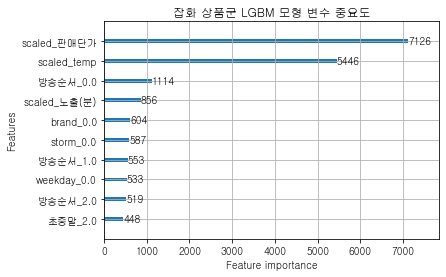

In [24]:
plot_importance(lgb_reg, max_num_features=10,title = '잡화 상품군 LGBM 모형 변수 중요도')
plt.savefig('./graphs/modeling/fea_im_item.png')

## 건강기능

In [25]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
X_train, X_test, y_train= train_final.loc[train_final['상품군']=='건강기능'].drop(['상품명','상품군','취급액','day'],axis=1),train_final.loc[train_final['상품군']=='건강기능','취급액'],test_final.loc[test_final['상품군']=='건강기능'].drop(['상품군','상품명','취급액','day'],axis=1)
y_idx = list(y_train.index)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818,
                           objective = 'regression',metric='mse',
                           learning_rate = 0.01,max_depth=7,num_leaves=63)
lgb_reg = lgb_reg.fit(X_train,X_test)
pred_lgb = list(lgb_reg.predict(y_train))
pred_df = pd.DataFrame({'index':y_idx,'취급액':pred_lgb})
final_df = pd.concat([final_df,pred_df],axis=0)
print(final_df.shape)

(624, 2)


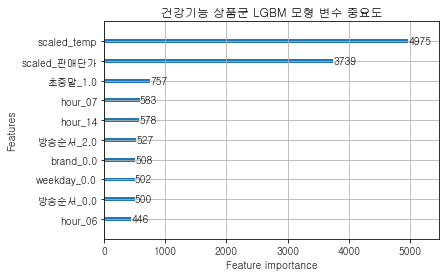

In [26]:
plot_importance(lgb_reg, max_num_features=10,title = '건강기능 상품군 LGBM 모형 변수 중요도')
plt.savefig('./graphs/modeling/fea_im_health.png')

## 농수축

In [27]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
X_train, X_test, y_train= train_final.loc[train_final['상품군']=='농수축'].drop(['상품명','상품군','취급액','day'],axis=1),train_final.loc[train_final['상품군']=='농수축','취급액'],test_final.loc[test_final['상품군']=='농수축'].drop(['상품군','상품명','취급액','day'],axis=1)
y_idx = list(y_train.index)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818,
                           objective = 'regression',metric='mse',
                           learning_rate = 0.05,max_depth=6,num_leaves=63)
lgb_reg = lgb_reg.fit(X_train,X_test)
pred_lgb = list(lgb_reg.predict(y_train))
pred_df = pd.DataFrame({'index':y_idx,'취급액':pred_lgb})
final_df = pd.concat([final_df,pred_df],axis=0)
print(final_df.shape)

(1048, 2)


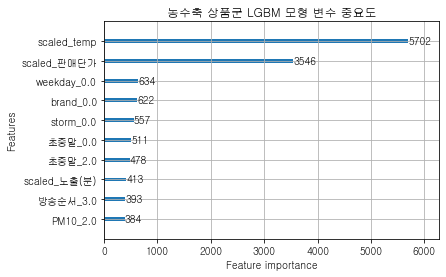

In [28]:
plot_importance(lgb_reg, max_num_features=10,title = '농수축 상품군 LGBM 모형 변수 중요도')
plt.savefig('./graphs/modeling/fea_im_industry.png')

## 침구

In [29]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
X_train, X_test, y_train= train_final.loc[train_final['상품군']=='침구'].drop(['상품명','상품군','취급액','day'],axis=1),train_final.loc[train_final['상품군']=='침구','취급액'],test_final.loc[test_final['상품군']=='침구'].drop(['상품군','상품명','취급액','day'],axis=1)
y_idx = list(y_train.index)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818,
                           objective = 'regression',metric='mse',
                           learning_rate = 0.05,max_depth=6,num_leaves=63)
lgb_reg = lgb_reg.fit(X_train,X_test)
pred_lgb = list(lgb_reg.predict(y_train))
pred_df = pd.DataFrame({'index':y_idx,'취급액':pred_lgb})
final_df = pd.concat([final_df,pred_df],axis=0)
print(final_df.shape)

(1120, 2)


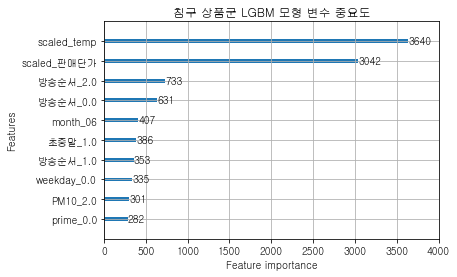

In [30]:
plot_importance(lgb_reg, max_num_features=10,title = '침구 상품군 LGBM 모형 변수 중요도')
plt.savefig('./graphs/modeling/fea_im_bed.png')

## 생활용품

In [31]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
X_train, X_test, y_train= train_final.loc[train_final['상품군']=='생활용품'].drop(['상품명','상품군','취급액','day'],axis=1),train_final.loc[train_final['상품군']=='생활용품','취급액'],test_final.loc[test_final['상품군']=='생활용품'].drop(['상품군','상품명','취급액','day'],axis=1)
y_idx = list(y_train.index)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818,
                           objective = 'regression',metric='mse',
                           learning_rate = 0.1,max_depth=7,num_leaves=63)
lgb_reg = lgb_reg.fit(X_train,X_test)
pred_lgb = list(lgb_reg.predict(y_train))
pred_df = pd.DataFrame({'index':y_idx,'취급액':pred_lgb})
final_df = pd.concat([final_df,pred_df],axis=0)
print(final_df.shape)

(1468, 2)


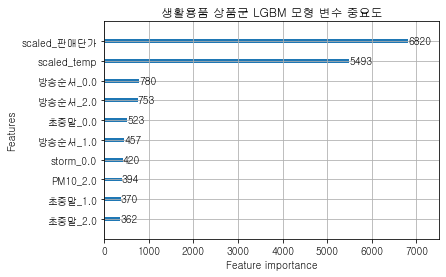

In [32]:
plot_importance(lgb_reg, max_num_features=10,title = '생활용품 상품군 LGBM 모형 변수 중요도')
plt.savefig('./graphs/modeling/fea_im_life.png')

## 주방

In [33]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
X_train, X_test, y_train= train_final.loc[train_final['상품군']=='주방'].drop(['상품명','상품군','취급액','day'],axis=1),train_final.loc[train_final['상품군']=='주방','취급액'],test_final.loc[test_final['상품군']=='주방'].drop(['상품군','상품명','취급액','day'],axis=1)
y_idx = list(y_train.index)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818,
                           objective = 'regression',metric='mse',
                           learning_rate = 0.1,max_depth=6,num_leaves=63)
lgb_reg = lgb_reg.fit(X_train,X_test)
pred_lgb = list(lgb_reg.predict(y_train))
pred_df = pd.DataFrame({'index':y_idx,'취급액':pred_lgb})
final_df = pd.concat([final_df,pred_df],axis=0)
print(final_df.shape)

(1740, 2)


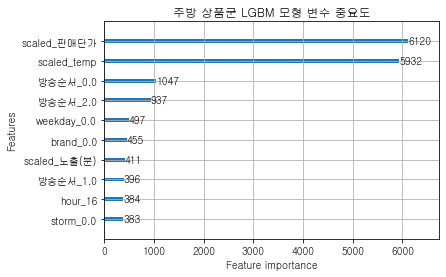

In [34]:
plot_importance(lgb_reg, max_num_features=10,title = '주방 상품군 LGBM 모형 변수 중요도')
plt.savefig('./graphs/modeling/fea_im_kitchen.png')

## 이미용

In [35]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
X_train, X_test, y_train= train_final.loc[train_final['상품군']=='이미용'].drop(['상품명','상품군','취급액','day'],axis=1),train_final.loc[train_final['상품군']=='이미용','취급액'],test_final.loc[test_final['상품군']=='이미용'].drop(['상품군','상품명','취급액','day'],axis=1)
y_idx = list(y_train.index)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818,
                           objective = 'regression',metric='mse',
                           learning_rate = 0.01,max_depth=6,num_leaves=63)
lgb_reg = lgb_reg.fit(X_train,X_test)
pred_lgb = list(lgb_reg.predict(y_train))
pred_df = pd.DataFrame({'index':y_idx,'취급액':pred_lgb})
final_df = pd.concat([final_df,pred_df],axis=0)
print(final_df.shape)

(1907, 2)


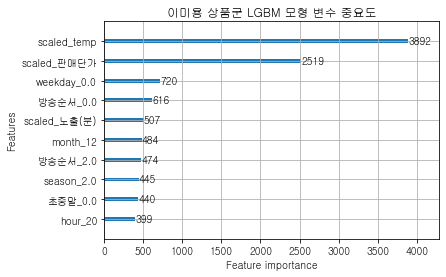

In [36]:
plot_importance(lgb_reg, max_num_features=10,title = '이미용 상품군 LGBM 모형 변수 중요도')
plt.savefig('./graphs/modeling/fea_im_beauty.png')

## 가전

In [37]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
X_train, X_test, y_train= train_final.loc[train_final['상품군']=='가전'].drop(['상품명','상품군','취급액','day'],axis=1),train_final.loc[train_final['상품군']=='가전','취급액'],test_final.loc[test_final['상품군']=='가전'].drop(['상품군','상품명','취급액','day'],axis=1)
y_idx = list(y_train.index)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818,
                           objective = 'regression',metric='mse',
                           learning_rate = 0.05,max_depth=6,num_leaves=63)
lgb_reg = lgb_reg.fit(X_train,X_test)
pred_lgb = list(lgb_reg.predict(y_train))
pred_df = pd.DataFrame({'index':y_idx,'취급액':pred_lgb})
final_df = pd.concat([final_df,pred_df],axis=0)
print(final_df.shape)

(2396, 2)


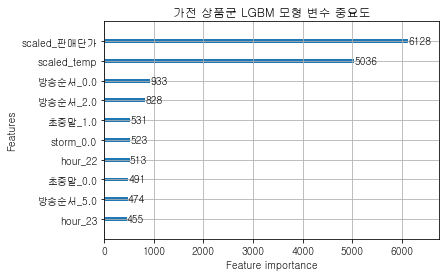

In [38]:
plot_importance(lgb_reg, max_num_features=10,title = '가전 상품군 LGBM 모형 변수 중요도')
plt.savefig('./graphs/modeling/fea_im_appiance.png')

## 가구

In [39]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
X_train, X_test, y_train= train_final.loc[train_final['상품군']=='가구'].drop(['상품명','상품군','취급액','day'],axis=1),train_final.loc[train_final['상품군']=='가구','취급액'],test_final.loc[test_final['상품군']=='가구'].drop(['상품군','상품명','취급액','day'],axis=1)
y_idx = list(y_train.index)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818,
                           objective = 'regression',metric='mse',
                           learning_rate = 0.01,max_depth=6,num_leaves=63)
lgb_reg = lgb_reg.fit(X_train,X_test)
pred_lgb = list(lgb_reg.predict(y_train))
pred_df = pd.DataFrame({'index':y_idx,'취급액':pred_lgb})
final_df = pd.concat([final_df,pred_df],axis=0)
print(final_df.shape)

(2555, 2)


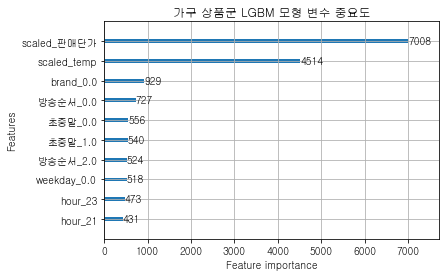

In [40]:
plot_importance(lgb_reg, max_num_features=10,title = '가구 상품군 LGBM 모형 변수 중요도')
plt.savefig('./graphs/modeling/fea_im_furniture.png')

## 의류

In [41]:
# -*- coding: utf-8 -*-
from tqdm.notebook import tqdm
X_train, X_test, y_train= train_final.loc[train_final['상품군']=='의류'].drop(['상품명','상품군','취급액','day'],axis=1),train_final.loc[train_final['상품군']=='의류','취급액'],test_final.loc[test_final['상품군']=='의류'].drop(['상품군','상품명','취급액','day'],axis=1)
y_idx = list(y_train.index)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, random_state=1818,
                           objective = 'regression',metric='mse',
                           learning_rate = 0.05,max_depth=6,num_leaves=63)
lgb_reg = lgb_reg.fit(X_train,X_test)
pred_lgb = list(lgb_reg.predict(y_train))
pred_df = pd.DataFrame({'index':y_idx,'취급액':pred_lgb})
final_df = pd.concat([final_df,pred_df],axis=0)
print(final_df.shape)

(2716, 2)


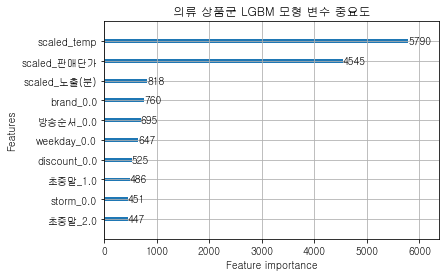

In [42]:
plot_importance(lgb_reg, max_num_features=10,title = '의류 상품군 LGBM 모형 변수 중요도')
plt.savefig('./graphs/modeling/fea_im_cloth.png')

In [43]:
with open('./pickles/final_predict_df.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(final_df, f)

## Predict

In [44]:
with open('./pickles/test_raw.pkl', 'rb') as f: # 원 Test 데이터 부르기
    test_raw = pickle.load(f)
    
real_test_raw = test_raw.copy()
real_test_raw = real_test_raw.rename(columns=real_test_raw.iloc[0])[1:]
real_test_raw.shape

(2891, 8)

In [45]:
final_df.index = test_idx
final_df = final_df.drop('index',axis=1)
final_df.head(3)

,취급액
index,
1,2.707608e+07
2,5.474901e+07
3,4.474984e+07


In [46]:
real_test_raw = real_test_raw.drop('취급액',axis=1)
real_final = pd.merge(real_test_raw,final_df,left_index=True,right_index=True, how='left')
real_final.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
1,2020-06-01 06:20:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,2.707608e+07
2,2020-06-01 06:40:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,5.474901e+07
3,2020-06-01 07:00:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,4.474984e+07
4,2020-06-01 07:20:00,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,2.528725e+07
5,2020-06-01 07:40:00,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,5.376168e+07


In [47]:
real_final.to_csv('./Data/데이터분석분야_챔피언리그_시로앤마로_submission.csv',encoding='utf-8',index=False)